In [2]:
!pip install hopsworks joblib scikit-learn pandas numpy matplotlib tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.6/691.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.6/258.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import hopsworks
import pandas as pd
from dotenv import load_dotenv
import os

# Load your .env with HOPSWORKS_API_KEY
load_dotenv()
api_key = os.getenv("HOPSWORKS_API_KEY")

project = hopsworks.login(api_key_value=api_key)
fs = project.get_feature_store()


Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1257623


In [2]:
feature_group = fs.get_feature_group(name="weather_data_2", version=1)
df = feature_group.read()
df.head()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.21s) 


,datetime,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,surface_pressure,cloud_cover,...,winddirection_10m,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index
0,2025-04-22 08:00:00+00:00,26.3,72.0,20.9,30.3,0.0,0.0,0.0,1011.3,0.0,...,9.0,82.4,38.0,1075.0,27.2,13.9,67.0,0.28,81.0,1.5
1,2025-07-28 00:00:00+00:00,28.4,80.0,24.6,32.8,0.0,0.0,0.0,998.2,96.0,...,262.0,58.8,24.3,207.0,14.5,11.0,48.0,0.80,61.0,0.0
2,2025-06-18 21:00:00+00:00,29.7,84.0,26.7,34.6,0.1,0.1,0.0,997.6,34.0,...,248.0,45.1,22.3,219.0,10.5,8.9,56.0,0.48,36.0,0.0
3,2025-06-01 03:00:00+00:00,29.2,79.0,25.2,33.8,0.0,0.0,0.0,997.1,41.0,...,233.0,40.5,17.2,147.0,4.1,5.3,71.0,0.47,33.0,0.0
4,2024-11-06 01:00:00+00:00,24.0,89.0,22.1,27.8,0.0,0.0,0.0,1013.6,0.0,...,329.0,49.6,30.6,472.0,44.5,9.1,35.0,0.18,6.0,0.0


In [6]:
import numpy as np
import pandas as pd

def calculate_aqi(pm25, pm10):
    return 0.5 * pm25 + 0.5 * pm10  # Simplified for now

# Use your actual column name 'datetime'
df['aqi'] = calculate_aqi(df['pm2_5'], df['pm10'])
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')
df = df.dropna()

# Time-based features
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month


In [10]:
def create_lagged_features(data, lag=72):
    X, y = [], []
    values = data[['aqi', 'temperature_2m', 'relative_humidity_2m', 'windspeed_10m', 'ozone']].values
    for i in range(lag, len(values)):
        X.append(values[i-lag:i])
        y.append(values[i, 0])  # Predict AQI
    return np.array(X), np.array(y)

X, y = create_lagged_features(df, lag=72)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (8726, 72, 5)
y shape: (8726,)


In [11]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 31s 157ms/step - loss: 1583.8563 - val_loss: 1087.1635
Epoch 2/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - loss: 947.5318 - val_loss: 671.0478
Epoch 3/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 28s 161ms/step - loss: 737.4431 - val_loss: 459.9041
Epoch 4/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 28s 162ms/step - loss: 599.1467 - val_loss: 355.9162
Epoch 5/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - loss: 611.6093 - val_loss: 283.2168
Epoch 6/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 26s 147ms/step - loss: 434.4822 - val_loss: 182.2812
Epoch 7/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - loss: 332.3649 - val_loss: 129.2912
Epoch 8/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - loss: 268.0020 - val_loss: 94.0070
Epoch 9/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 42s 160ms/step - loss: 301.3152 - val_loss: 74.0002
Epoch 10/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - loss: 291.2461 - val_loss: 58.0479
Epoch 11/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 26s 151ms/step - loss: 198.61

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Define custom accuracy metric for regression
def regression_accuracy(y_true, y_pred, tolerance=0.1):
    """
    Returns accuracy as % of predictions within ±tolerance of true values.
    tolerance = 0.1 means ±10%
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred).flatten()
    within_range = np.abs((y_true - y_pred) / y_true) <= tolerance
    return np.mean(within_range) * 100

accuracy = regression_accuracy(y_test, y_pred, tolerance=0.1)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"Accuracy (within ±10%): {accuracy:.2f}%")


55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step
MAE: 2.51
RMSE: 5.00
R²: 0.93
Accuracy (within ±10%): 82.25%


In [15]:
import joblib, os

model_dir = "aqi_lstm_model"
os.makedirs(model_dir, exist_ok=True)
model.save(f"{model_dir}/lstm_aqi_forecast.h5")

mr = project.get_model_registry()

model_meta = mr.python.create_model(
    name="AQI_LSTM_Forecaster",
    metrics={"MAE": mae, "RMSE": rmse, "R2": r2, "Accuracy": accuracy},
    description="LSTM model for 3-day AQI forecasting",
)

model_meta.save(model_dir)
print("✅ Model saved successfully in Hopsworks Model Registry!")


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /content/aqi_lstm_model/lstm_aqi_forecast.h5: 0.000%|          | 0/1454768 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1257623/models/AQI_LSTM_Forecaster/1
✅ Model saved successfully in Hopsworks Model Registry!


In [16]:
recent_data = df.tail(72)[['aqi', 'temperature_2m', 'relative_humidity_2m', 'windspeed_10m', 'ozone']].values
recent_data = np.expand_dims(recent_data, axis=0)
future_preds = []

for _ in range(72):  # next 72 hours = 3 days
    pred = model.predict(recent_data)[:, 0]
    future_preds.append(pred[0])
    new_entry = np.array([[pred[0], recent_data[0, -1, 1], recent_data[0, -1, 2], recent_data[0, -1, 3], recent_data[0, -1, 4]]])
    recent_data = np.concatenate([recent_data[:, 1:, :], np.expand_dims(new_entry, axis=1)], axis=1)

print("Predicted AQI for next 3 days:", future_preds[:10], "...")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85m

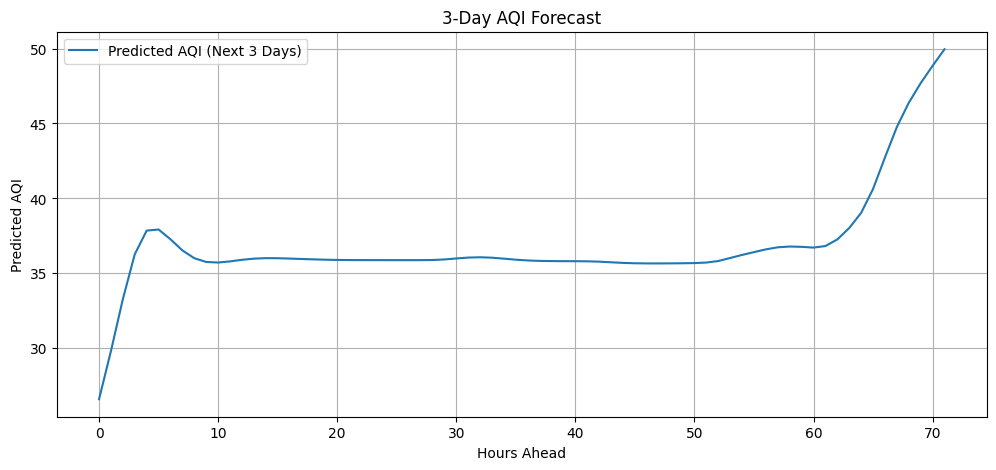

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(range(len(future_preds)), future_preds, label='Predicted AQI (Next 3 Days)')
plt.xlabel('Hours Ahead')
plt.ylabel('Predicted AQI')
plt.title('3-Day AQI Forecast')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
!pip install plotly


In [19]:
import plotly.graph_objects as go
from datetime import timedelta

# ✅ Get last 3 days of actual AQI
df_recent = df.tail(72*3).copy()  # last 3 days (72 hrs * 3)
actual_dates = df_recent['datetime']
actual_aqi = df_recent['aqi']

# ✅ Generate next 3 days of timestamps
last_timestamp = df_recent['datetime'].iloc[-1]
future_dates = [last_timestamp + timedelta(hours=i+1) for i in range(72)]

# ✅ Create Plotly figure
fig = go.Figure()

# Add actual AQI (past)
fig.add_trace(go.Scatter(
    x=actual_dates,
    y=actual_aqi,
    mode='lines+markers',
    name='Actual AQI (Past 3 Days)',
    line=dict(color='green', width=2)
))

# Add predicted AQI (future)
fig.add_trace(go.Scatter(
    x=future_dates,
    y=future_preds,
    mode='lines+markers',
    name='Predicted AQI (Next 3 Days)',
    line=dict(color='orange', width=2, dash='dot')
))

# Layout customization
fig.update_layout(
    title='🌤 AQI Forecast: Past vs Next 3 Days',
    xaxis_title='Date & Time',
    yaxis_title='Air Quality Index (AQI)',
    legend=dict(x=0, y=1.1, orientation="h"),
    template='plotly_white',
    hovermode='x unified'
)

fig.show()
